In [3]:
import pandas as pd
from torch.utils.data import Dataset


** load the data and pass it to the model in the right format. In PyTorch, this is handled by Datasets and DataLoaders. Let's start with building a PyTorch Dataset for our water potability data. WaterDataset to load the data from a CSV file. **

** three methods which PyTorch expects a Dataset to have:

    .__init__() to load the data,
    .__len__() to return data size,
    .__getitem()__ to extract features and label for a single sample**

In [4]:
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy().astype(np.float32)

the WaterDataset you just created is now available f
The next step in preparing the training data is to set up a DataLoader. A PyTorch DataLoader can be created from a Dataset to load data, split it into batches, and perform transformations on the data if desired. Then, it yields a data sample ready for training.


In [5]:
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx,-1]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [ ]:
from torch.utils.data import Dataset, DataLoader
# Create an instance of the WaterDataset
dataset_train = WaterDataset(
    "water_train.csv"
)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

OOP approach to define the model architecture. Recall that this requires setting up a model class and defining two methods inside it:

    .__init__(), in which you define the layers you want to use;

    forward(), in which you define what happens to the model inputs once it receives them; this is where you pass inputs through pre-defined layers.

Let's build a model with three linear layers and ReLU activations. After the last linear layer, you need a sigmoid activation instead, which is well-suited for binary classification tasks like our water potability prediction problem. Here's the model defined using nn.Sequential(), which you may be more familiar with:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

# day 12

# Optimizers, Training Loop, and Model Evaluation in PyTorch

This guide distills the essentials of training and evaluating neural networks in PyTorch, with a focus on how optimizers work and how to measure model performance. It also includes foundational concepts you need to master for building robust deep learning systems.

---

## 1. The Role of Optimizers in Training

Optimizers are algorithms that adjust model parameters (weights and biases) to minimize the loss function. They use gradients computed during backpropagation to decide:

- **Direction**: Whether to increase or decrease a parameter.
- **Magnitude**: How much to change the parameter.

The goal is to find parameter values that reduce prediction error and improve generalization.

---

## 2. PyTorch Training Loop: Step-by-Step

A typical training loop in PyTorch includes:

1. **Define the loss function**  
   - For binary classification, use **Binary Cross-Entropy (BCE) Loss**.

2. **Initialize the optimizer**  
   - Example: **Stochastic Gradient Descent (SGD)** with a learning rate of 0.01.

3. **Iterate over epochs and batches**  
   - Loop through the dataset multiple times (epochs), processing small chunks (batches).

4. **Clear gradients**  
   - Reset gradients to zero before each batch using `optimizer.zero_grad()`.

5. **Forward pass**  
   - Pass input data through the model to get predictions.

6. **Compute loss**  
   - Compare predictions with ground-truth labels using the loss function.

7. **Backward pass**  
   - Use `loss.backward()` to compute gradients of the loss with respect to model parameters.

8. **Optimization step**  
   - Call `optimizer.step()` to update parameters using the computed gradients.

---

## 3. How Optimizers Work

- Gradients indicate the direction and steepness of the loss surface.
- A **positive gradient** means the parameter should be **decreased**.
- A **negative gradient** means the parameter should be **increased**.
- The **learning rate** controls how big each update is.

---

## 4. Popular Optimizers in PyTorch

| Optimizer | Description | Strengths | Limitations |
|----------|-------------|-----------|-------------|
| **SGD** | Updates parameters using gradients and a fixed learning rate | Simple and efficient | May struggle with complex loss surfaces |
| **Adagrad** | Adapts learning rate for each parameter based on frequency of updates | Good for sparse data | Learning rate decays too quickly |
| **RMSprop** | Uses moving average of squared gradients to scale learning rate | Handles non-stationary objectives well | Requires tuning decay rate |
| **Adam** | Combines RMSprop and momentum for adaptive updates | Fast convergence, widely used | May generalize poorly in some cases |

**Adam** is often the default choice due to its balance of speed and stability.

---

## 5. Model Evaluation Workflow

Once training is complete, evaluate the model on unseen test data:

1. **Switch to evaluation mode**  
   - Use `model.eval()` to disable dropout and batch normalization.

2. **Disable gradient tracking**  
   - Use `torch.no_grad()` to save memory and speed up inference.

3. **Forward pass on test data**  
   - Get predicted probabilities from the model.

4. **Convert probabilities to labels**  
   - Apply a threshold (e.g., 0.5) to classify outputs.

5. **Compute accuracy**  
   - Use metrics like binary accuracy to assess performance.

**Example Result**: Achieving 67% accuracy on a small dataset is a solid baseline for further improvement.

---

## 6. Key Concepts to Master

To build and evaluate deep learning models effectively, you should understand:

- **Loss functions**: BCE, CrossEntropy, MSE, etc.
- **Gradient flow**: How gradients propagate through layers.
- **Learning rate scheduling**: Adjusting learning rate during training.
- **Regularization**: Techniques like dropout and weight decay to prevent overfitting.
- **Evaluation metrics**: Accuracy, precision, recall, F1 score, ROC-AUC.
- **Early stopping**: Halting training when validation performance stops improving.
- **Batch size and epochs**: Their impact on training dynamics and generalization.

---

## 7. Final Takeaways

- Optimizers are the engine of learning — choose them wisely.
- Training loops must be carefully structured to ensure correct gradient flow and parameter updates.
- Evaluation is not just about accuracy — it’s about understanding model behavior and generalization.
- Mastering these fundamentals sets the stage for advanced topics like transfer learning, fine-tuning, and deployment.



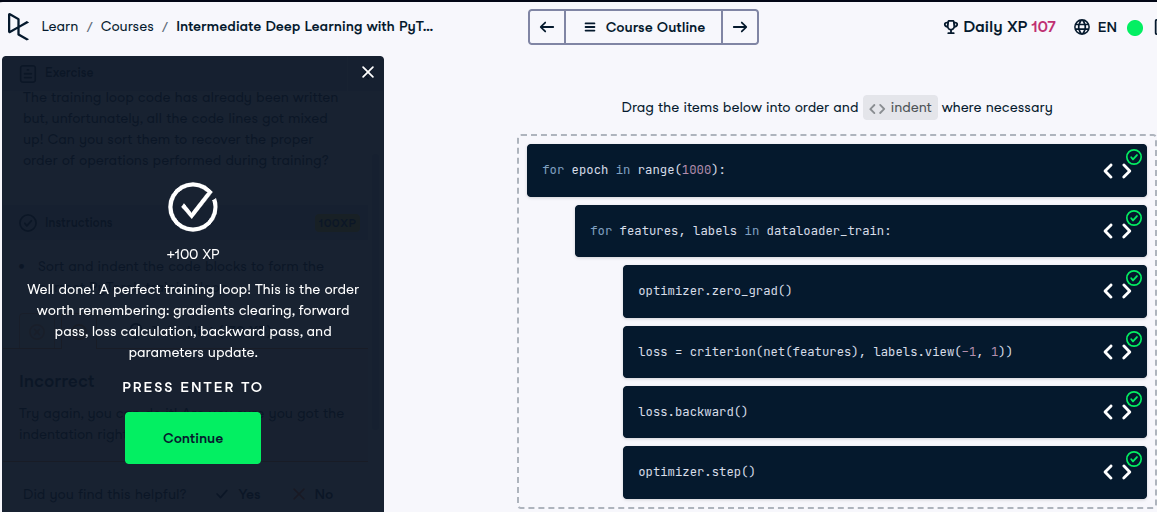

In [27]:
def train_model(optimizer, net, num_epochs, dataloader_train, criterion):
    net.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels in dataloader_train:
            optimizer.zero_grad()               # Clear previous gradients
            outputs = net(features.float())     # Forward pass
            labels = labels.view(-1, 1).float() # Reshape labels for BCE loss
            loss = criterion(outputs, labels)   # Compute loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update parameters
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")


In [ ]:
import torch.optim as optim

net = Net()

# Define the SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

In [ ]:
import torch.optim as optim

net = Net()

# Define the RMSprop optimizer
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

import torch.optim as optim

net = Net()

# Define the Adam optimizer
optimizer = optim.Adagrad(net.parameters())

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

With the training loop sorted out, you have trained the model for 1000 epochs, and it is available to you as net. You have also set up a test_dataloader in exactly the same way as you did with train_dataloader before—just reading the data from the test rather than the train directory.

You can now evaluate the model on test data. To do this, you will need to write the evaluation loop to iterate over the batches of test data, get the model's predictions for each batch, and calculate the accuracy score for it. Let's do it!

In [ ]:
import torch
from torchmetrics import Accuracy

# Set up binary accuracy metric
acc = Accuracy(task="binary")

net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        # Get predicted probabilities for test data batch
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

# Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")


# Gradient Stability in Neural Networks: Vanishing, Exploding, and Solutions

Training deep neural networks often involves navigating gradient instability. This guide explains the causes of vanishing and exploding gradients, and outlines proven strategies to stabilize training using weight initialization, activation functions, and batch normalization.

---

## 1. Vanishing Gradients

Vanishing gradients occur when gradients become increasingly small during backpropagation. This leads to:

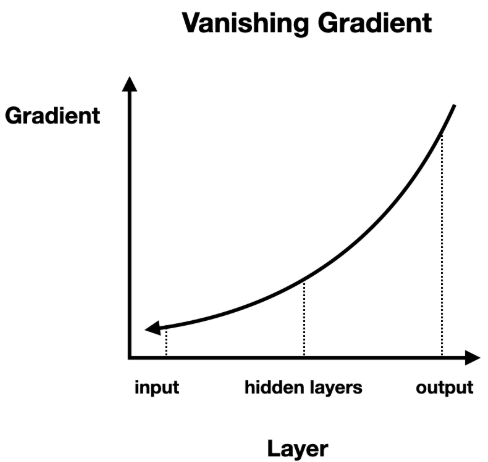

- **Minimal updates** to early layers
- **Slow or stalled learning**
- **Poor convergence**, especially in deep networks

**Why it happens**:
- Activation functions like Sigmoid squash outputs into small ranges.
- Repeated multiplication of small gradients across layers causes exponential decay.

---

## 2. Exploding Gradients

Exploding gradients occur when gradients grow excessively large during backpropagation. This leads to:


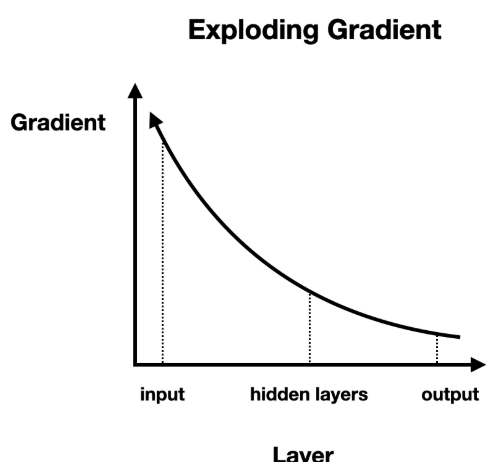 

- **Unstable training**
- **Diverging loss**
- **Numerical overflow or NaNs**

**Why it happens**:
- Poor weight initialization
- Deep architectures without normalization
- Large learning rates

---

## 3. Three-Step Solution to Gradient Instability

To stabilize gradients and ensure effective learning, use this three-part strategy:

### A. Proper Weight Initialization

When layers are created in PyTorch, their weights are randomly initialized. However, naive initialization can cause gradient instability.

**Goal**: Ensure that:
- Input and output variances are similar
- Gradient variance is preserved across layers


**He Initialization (Kaiming Initialization)**:
- Designed for ReLU and similar activations
- Preserves variance across layers
- Use `torch.nn.init.kaiming_uniform_()` on layer weights
- For layers with Sigmoid activation, specify `nonlinearity='sigmoid'`
- 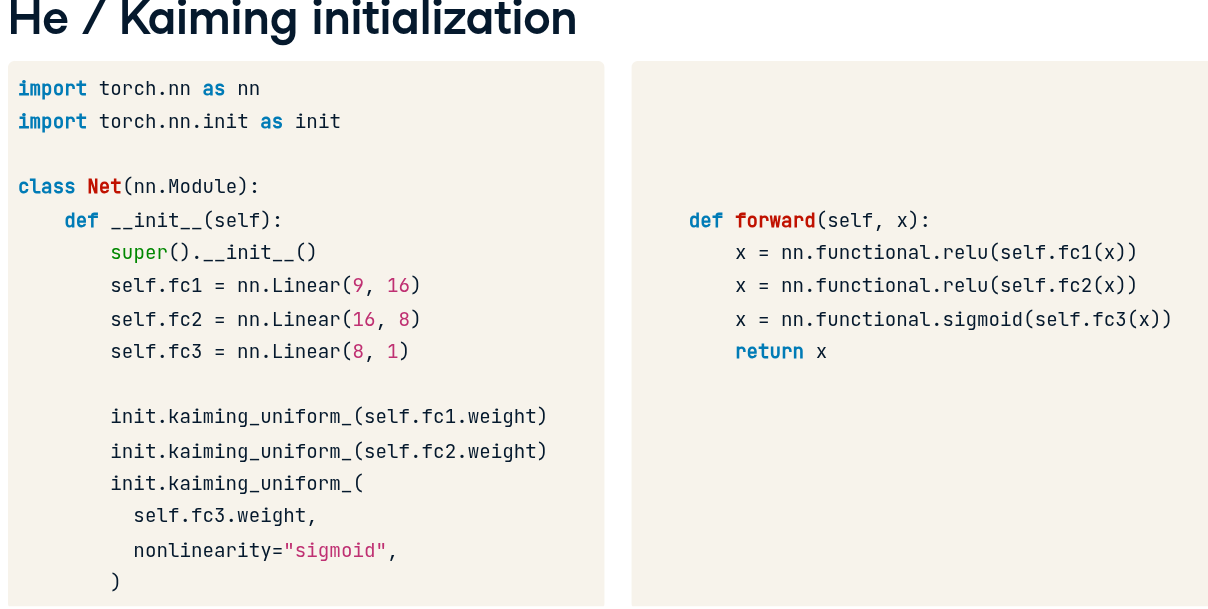

**Why it matters**:
- Prevents exploding/vanishing gradients from the start
- Improves convergence speed and stability

---

### B. Activation Functions

Activation functions introduce non-linearity and influence gradient flow.

| Activation | Description | Pros | Cons |
|------------|-------------|------|------|
| **ReLU** | Outputs zero for negative inputs | Fast, simple, gradient-preserving | Dying neuron problem |
| **ELU** | Exponential Linear Unit | Non-zero gradients for negative inputs | Slightly more compute |
| **Sigmoid** | Squashes output to (0,1) | Good for output layers | Causes vanishing gradients |
| **Softmax** | Converts logits to probabilities | Used in multi-class output layers | Not ideal for hidden layers |

**ELU Advantage**:
- Avoids dying neurons
- Output mean near zero → better gradient flow
- More robust than ReLU in deeper networks

---

### C. Batch Normalization

Batch normalization normalizes layer outputs to stabilize training dynamics.

**How it works**:
1. Subtract mean and divide by standard deviation
2. Learnable scale and shift parameters adjust normalized output
3. Applied after linear layers and before activation functions
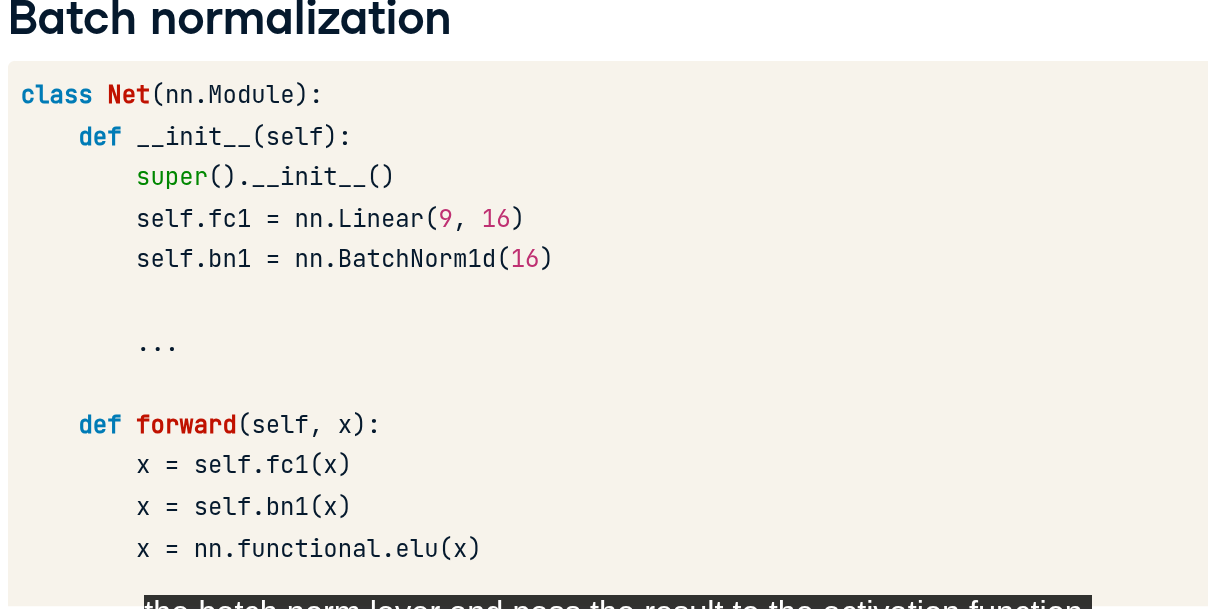
**Benefits**:
- Reduces internal covariate shift
- Speeds up convergence
- Makes training more robust to learning rate and initialization
- Helps prevent both vanishing and exploding gradients

**PyTorch Implementation**:
- Use `nn.BatchNorm1d(output_size)` in the `__init__` method
- Apply it in `forward()` before activation

---

## 4. Best Practices for Stable Training

- Use **He initialization** for ReLU-based networks
- Prefer **ELU** or **Leaky ReLU** to avoid dying neurons
- Apply **BatchNorm** after each linear layer
- Monitor gradients during training to detect instability
- Use gradient clipping if necessary (e.g., `torch.nn.utils.clip_grad_norm_`)
- Choose optimizers like **Adam** that adapt learning rates and incorporate momentum

---

## 5. Summary Table

| Technique           | Purpose                            | PyTorch Tool                     |
|---------------------|------------------------------------|----------------------------------|
| He Initialization   | Preserve variance across layers    | `torch.nn.init.kaiming_uniform_` |
| ELU Activation       | Avoid dying neurons, better flow   | `nn.functional.elu`              |
| Batch Normalization | Normalize outputs, stabilize training | `nn.BatchNorm1d`               |
| Gradient Clipping   | Prevent exploding gradients         | `clip_grad_norm_`                |

---

## 6. Final Takeaways

Gradient stability is foundational to successful deep learning. By combining smart initialization, robust activations, and normalization techniques, you can build models that learn efficiently and generalize well. These strategies are not just fixes — they’re design principles for scalable, reliable neural networks.



## Initialization and activation
The problems of unstable (vanishing or exploding) gradients are a challenge that often arises in training deep neural networks. In this and the following exercises, expand the model architecture that you built for the water potability classification task to make it more immune to those problems.

As a first step improve the weights initialization by using He (Kaiming) initialization strategy. To do so, call the proper initializer from the torch.nn.init module, which has been imported for you as init. Next, you will update the activations functions from the default ReLU to the often better ELU.

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Pass x through the second set of layers
        x = self.bn1(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Pass x through the second set of layers
        x = self.bn1(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

# full working  iimplementation

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
import torch.nn.init as init

In [2]:
# Define the WaterDataset class (PyTorch Dataset)
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array
        self.data = df.to_numpy().astype(np.float32)  # Ensure float32 for PyTorch
        
    def __len__(self):
        # Return the number of data samples
        return len(self.data)
    
    def __getitem__(self, idx):
        # Features are all columns except the last one
        features = self.data[idx, :-1]
        # Label is the last column
        label = self.data[idx, -1]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [3]:
# Define the neural network model (PyTorch Model, Initialization, Activations, Batch Normalization)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.fc1 = nn.Linear(9, 16)  # Input: 9 features, Output: 16
        self.bn1 = nn.BatchNorm1d(16)  # Batch normalization for 16 features
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)  # Batch normalization for 8 features
        self.fc3 = nn.Linear(8, 1)
        ss`
        # Kaiming initialization to prevent vanishing/exploding gradients
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        init.kaiming_uniform_(self.fc3.weight, nonlinearity='sigmoid')
    
    def forward(self, x):
        # First layer: Linear -> BatchNorm -> ELU
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.elu(x)  # ELU activation for better gradient flow
        
        # Second layer: Linear -> BatchNorm -> ELU
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.elu(x)
        
        # Output layer: Linear -> Sigmoid
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid for binary classification
        return x

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Create training and test datasets (PyTorch Dataset)
dataset_train = WaterDataset("water_train.csv")
dataset_test = WaterDataset("water_test.csv")

# Create DataLoaders (PyTorch DataLoader)
dataloader_train = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True
)
dataloader_test = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False
)


In [5]:
# Initialize the model, optimizer, and loss function (Optimizers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification

# Training loop
def train_model(model, dataloader, criterion, optimizer, num_epochs=37):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device).view(-1, 1)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print epoch loss
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")



In [7]:
# Model evaluation
def evaluate_model(model, dataloader):
    model.eval()
    acc = Accuracy(task="binary").to(device)
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device).view(-1, 1)
            outputs = model(features)
            preds = (outputs >= 0.5).float()
            acc(preds, labels)
    
    test_accuracy = acc.compute()
    print(f"Test accuracy: {test_accuracy:.4f}")
    return test_accuracy

# Train the model
print("Training the model...")
train_model(model, dataloader_train, criterion, optimizer, num_epochs=37)

# Evaluate the model
print("\nEvaluating the model...")
evaluate_model(model, dataloader_test)

Training the model...
Epoch 1/37, Loss: 0.6638
Epoch 2/37, Loss: 0.6562
Epoch 3/37, Loss: 0.6545
Epoch 4/37, Loss: 0.6568
Epoch 5/37, Loss: 0.6527
Epoch 6/37, Loss: 0.6499
Epoch 7/37, Loss: 0.6557
Epoch 8/37, Loss: 0.6468
Epoch 9/37, Loss: 0.6473
Epoch 10/37, Loss: 0.6492
Epoch 11/37, Loss: 0.6449
Epoch 12/37, Loss: 0.6428
Epoch 13/37, Loss: 0.6401
Epoch 14/37, Loss: 0.6366
Epoch 15/37, Loss: 0.6375
Epoch 16/37, Loss: 0.6381
Epoch 17/37, Loss: 0.6334
Epoch 18/37, Loss: 0.6258
Epoch 19/37, Loss: 0.6268
Epoch 20/37, Loss: 0.6199
Epoch 21/37, Loss: 0.6206
Epoch 22/37, Loss: 0.6322
Epoch 23/37, Loss: 0.6107
Epoch 24/37, Loss: 0.6136
Epoch 25/37, Loss: 0.6112
Epoch 26/37, Loss: 0.6069
Epoch 27/37, Loss: 0.6056
Epoch 28/37, Loss: 0.5990
Epoch 29/37, Loss: 0.6002
Epoch 30/37, Loss: 0.6084
Epoch 31/37, Loss: 0.6127
Epoch 32/37, Loss: 0.6019
Epoch 33/37, Loss: 0.5978
Epoch 34/37, Loss: 0.6015
Epoch 35/37, Loss: 0.5994
Epoch 36/37, Loss: 0.5949
Epoch 37/37, Loss: 0.5875

Evaluating the model...


tensor(0.6581)